These notes are a result of my preparation for a midterm exam in [Pascal Poupart](https://cs.uwaterloo.ca/~ppoupart)'s [course on Machine Learning](https://cs.uwaterloo.ca/~ppoupart/teaching/cs485-winter16/) at University of Waterloo in the winter 2016 term.

## Introduction

Definition by Tom Mitchell (1988): "A computer program is said to learn from **experience E** with respect to some class of **tasks T** and **performance measure P** if its performance for tasks in T, as measured by P, improves with experience E."

Inductive Learning: given a training set of examples of the form $(x, f(X))$, return a function $h$ (**hypothesis**) that approximates $f$ (**true underlying function**).

The quality measure for hypotheses is **generalization**. A good hypothesis will generalize well, i.e., predict unseen examples correctly. **Ockham's razor** suggests to prefer the simplest hypothesis consistent with the input data.

Two different types of inductive learning:

* **Classification**: range/output space of $f$ is categorical (or discrete)
* **Regression**: range/output space of $f$ is continuous

**Hypothesis space $H$**: set of all possible $h$

**Consistency**: $h$ is consistent if it agrees with $f$ on all examples; it is not always possible to find a consistent $h$ (e.g., due to an insufficient $H$ or noisy input data)

**Realizability**: a learning problem is realizable if and only if $f$ is in $H$

In general, we will observe a tradeoff between **expressiveness** (i.e., the size of $H$) and the **complexity** of finding a good $h$.

**Overfitting**: given a hypothesis space $H$, a hypothesis $h \in H$ is said to overfit the training data if there exists some alternative hypothesis $h' \in H$ such that $h$ has smaller error than $h'$ over the training examples, but $h'$ has smaller error than $h$ over the entire distribution of instances.

**$k$-fold cross-validation:** run $k$ experiments, each time putting aside $\frac{1}{k}$ of the data to test on and, finally, compute the average accuracy of the experiments

## Decision Trees

Decision trees (a.k.a. **C**lassification **a**nd **R**egression **T**rees [CART]) represent disjunctions (OR) of conjunctions (AND) of constraints of attribute values.

Decision trees have the following **structure**:

* **nodes**: attributes
* **edges**: attribute values
* **leaves**: classes / regression values

**Quality measure** for decision trees:

* small size
* high consistency

**Greedy induction** of a decision tree:

* depth-first search like construction
* a good attribute splits the examples into subsets that are ideally all from the same class or, in other words, that minimizes the residual error

**Residual error for classification**:

||Error Frequency|Gini Index|Entropy|
|---|---|---|---|
|**Definition**|$Q_\tau=\#\tau-max_k\#k$|$Q_\tau=\sum_kp_\tau(k)(1-p_\tau(k))$|$Q_t=-\sum_kp_\tau(k) \ ld \ p_\tau(k)$|
|**Explanation**|Number of examples in leaf $\tau$ minus maximum number of examples in leaf $\tau$ that belong to any class $k$|Expected misclassification when choosing the class according to $p_\tau(k)$|Expected # of bits to encode the class of an instance chosen at random according to $p_\tau(k)$|

**Variables:**

* $\tau$: index for leaf $\tau$
* $k$: index for class $k$
* $\#\tau$: number of examples in leaf $\tau$
* $\#k$: number of examples in leaf $\tau$ belonging to class $k$
* $p_\tau(k) = \frac{\#k}{\#\tau}$

**Residual error for regression**:

* Let $t_n = f(x_n)$ be the target for the $n^th$ example.
* Let $y_t$ be the value returned by leaf $\tau$.
* Let $R_\tau$ be the set of examples in leaf $\tau$.
* Euclidean error for leaf $\tau$: $Q_\tau=\sum_{n \in R_\tau}(t_n-y_n)^2$

**Choosing the best attribute** for the next decision layer in the tree:

* In leaf $\tau$, choose attribute $A$ that reduces the residual error the most when expanded:
* $A^*=argmax_AQ_\tau-\sum_{a \in A}p_\tau(A=a)Q_{\tau a}$, where
  * $p_\tau(A=a)=\frac{\#(A=a)}{\#\tau}$ denotes the proportion of examples with value $a$ (in attribute $A$) inside node $\tau$
  * $\tau a$ indexes the node reached by following the edge for attribute value $a$, starting from node $\tau$
  
**Techniques to avoid overfitting:**

* Stop learning when the curve for testing accuracy, plotted against the tree size, goes down again; this is in practice sometimes hard to achieve because the curve might exhibit high fluctuation
* Pruning of statistically irrelevant nodes in a bottom-up fashion
  * Remove nodes that improve testing accuracy by less than some threshold
  * Regularization: add a penalty term that reflects the tree complexity (e.g., $\|T\|=$ #leaves in the tree) and remove leaves with a negative "regularized" error reduction: $Q_\tau-\sum_{a \in A}p_\tau(A=a)Q_{\tau a}-\lambda\|T\|$

## K-Nearest Neighbors

In the limit, single-attribute thresholding to construct decision trees for attributes with continouous inputs will lead to a full tree with one example per tree. Decision boundaries will always axis-aligned. A better approach without this restriction is $K$-Nearest Neighbors.

**Approach:**

* Let $knn(x)$ be the $K$ nearest neighbors of $x$ according to distance $d$
* Label $y_x=mode(\{y_x' \ \| \ x' \in knn(x)\})$, i.e., the most frequent label among the $K$ nearest neighbors
* $K$ controls the degree of smoothing and can be optimized using $k$-fold cross-validation (if $K$ is too small this will lead to overfitting; if $K$ is too high this will lead to underfitting)

**Comparison of complexity** between decision trees and $K$-Nearest Neighbors with respect to:

* $N$: size of training set
* $M$: number of attributes

||Training &nbsp;  &nbsp;  &nbsp; |Testing &nbsp;  &nbsp;  &nbsp; |
|---|---|---|
|**Decision Tree**|$O(M^2N)$|$O(M)$|
|**$K$-Nearest Neighbors**|$O(MN)$|$O(MN)$|

A good visualization of the decision boundaries for the two-dimensional 1-Nearest Neighbor case assuming Euclidean distance is the Voronoi diagram:

(-0.086231550409317764, 0.98264119063611655)

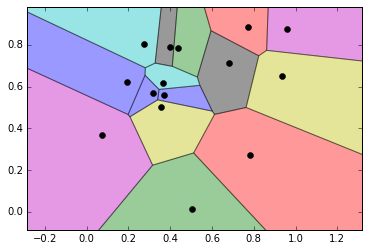

In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
np.random.seed(1234)
points = np.random.rand(15, 2)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

## Linear Regression

**Data**: $\{(x_1, t_1),(x_2,t_2),...,(x_N,t_N)\}$ where $x_n \in \mathbb{R}^D$ and $t_n \in \mathbb{R}$

**Problem**: find linear hypothesis $h$ that maps $x$ to $t$; in other words, try to find a weight vector $w \in \mathbb{R}^{D+1}$ so that the error for $h(x,w)=w^T\overline{x}$ with $\overline{x}=\begin{pmatrix} 1 \\ x \end{pmatrix}$ over all $x$ in the dataset is minimal

**Solution**: $ Aw=b $ with:

* $A=\sum_{n=1}^N\overline{x}_n\overline{x}_n^T$ (invertible if the training instances span $\mathbb{R}^{D+1}$)
* $b=\sum_{n=1}^Nt_n\overline{x}_n$

**Tikhonov Regularization**: a technique, applied to avoid a form of overfitting where small changes to the input data lead to big changes in the learned weight vector: $(\lambda I+A)w=b$. The greater $\lambda$ the smaller the magnitude of $w$ will be.

## Statistical Learning

**Idea**: learning simply reduces the uncertainty in our knowledge of the world

**Marginal Probability Distribution**: specification of a probability for each event in our sample space; all probabilities must sum up to $1$

**Joint Probability Distribution**: specification of probabilities for all combinations of events: $Pr(A=a
\wedge B=b)$ for all $a$, $b$

**Marginalization** (sumout rule): $Pr(A=a)=\sum_bPr(A=a
\wedge B=b)$

**Conditional Probability**: fraction of worlds in which $B$ is true that also have $A$ true: $Pr(A \mid B)=\frac{Pr(A \wedge B)}{Pr(B)}$; also $Pr(A \wedge B)=Pr(A \mid B) \ Pr(B)$

**Bayes' Rule**: $Pr(B \mid A)=\frac{Pr(A \mid B) \ Pr(B)}{Pr(A)}$

**Bayesian Inference**: $P(H \mid e)=kP(e \mid H) \ P(H)$

* $H$: hypothesis
* $e$: evidence
* $P(H)$: **prior** probability of $H$
* $P(e \mid H)=\prod_nP(e_n \mid H)$: **likelihood** of observing $e$, given $H$
* $P(H \mid e)$: **posterior** probability of $H$, given $e$
* $k$: normalizing factor, applied so that all posteriors sum up to $1$

**Bayesian Prediction**: $P(X \mid e)=\sum_iP(X \mid h_i) \ P(h_i \mid e)$

**Properties of Bayesian Learning**: optimal and not prone to overfitting, but potentially intractable if the hypothesis space is large

**Approximations of Bayesian Learning**:

* **Maximum a Posteriori (MAP)**:
  * making predictions, based on the most probable hypothesis $h_{MAP}=argmax_{h_i}P(h_i \mid e)$
  * less accurate than Bayesian prediction, but both converge in accuracy as data increases
  * controlled overfitting (prior can be used to penalize complex hypotheses)
  * MAP for linear regression leads to regularized least square problem
* **Maximum Likelihood (ML)**:
  * MAP with uniform prior: $h_{ML}=argmax_{h_i}P(e \mid h_i)$
  * less accurate than Bayesian and MAP prediction, but all three converge in accuracy as data increases
  * prone to overfitting
  * ML for linear regression leads to non-regularized least square problem
  
**Bias-Variance Decomposition** for linear regression: $expected \ loss = (bias)^2 + variance + noise$

* bias increases as regularization parameter $\lambda$ increases
* variance decreases as regularization parameter $\lambda$ increases
* noise is constant

## Mixture of Gaussians

**Purpose**: linear classification technique

**Assumptions**:

* $Pr(C=c_k)=\pi_k$: prior probability of class $k$
* $Pr(x \mid C=c_k) \propto e^{-0.5(x-\mu_k)^T\Sigma^{-1}(x-\mu_k)}$: likelihood of data point $x$, given class $k$, is a Gaussian distribution with the same covariance matrix $\Sigma$ for all classes
* $Pr(C=c_k \mid x)=kPr(x \mid C=c_k)Pr(C=c_k)$: posterior probability of class $k$, given data point $x$

**For two classes $A$ and $B$** (using sigmoid):

$Pr(C=A)=\sigma(w^Tx+w_0)$ where

* $\sigma(a) = \frac{1}{1+e^{-a}}$ (sigmoid function)
* $w=\Sigma^{-1}(\mu_A-\mu_B)$
* $w_0=-0.5\mu_A^T\Sigma^{-1}\mu_A+0.5\mu_B^T\Sigma^{-1}\mu_B+ln\frac{\pi_A}{\pi_B}$
* $\pi_k:$ fraction of training examples that belong to class $k$ (via maximum likelihood)
* $\mu_k:$ empirical mean of all training examples that belong to class $k$ (via maximum likelihood)
* $\Sigma=\frac{S_A+S_B}{N}$: normalized sum of covariance matrices (via maximum likelihood)
* $S_k=\sum_{n \in c_k}(x_n-\mu_k)(x_n-\mu_k)^T$

**For multiple classes** (using softmax):

$Pr(C=c_k \mid x)=\frac{e^{w_k^T\overline{x}}}{\sum_je^{w_j^T\overline{x}}}$

**Prediction**: best class $k^*=argmax_kPr(c_k \mid x)$

## Logistic Regression

**Purpose**: linear classification technique (can be viewed as a regression where the goal is to estimate a posterior probability which is continuous)

**Assumption**: $Pr(x \mid C=c_k)$ are members of the exponential family: $Pr(x \mid \Theta_k)=exp(\Theta_k^TT(x)-A(\Theta_k)+B(x))$

**Derivation**: $Pr(C=c_k \mid x)=\sigma(w^T\overline{x})$: the posterior probability of class $k$ is a sigmoid logistic linear in $x$ (or softmax linear in $x$ for more than two classes)

**Idea**: learning $Pr(C=c_k \mid x)$ directly by maximum likelihood

**Implementation for binary classification**:

* $y \in \{0,1\}$
* $w^*=argmax_w\prod_n\sigma(w^T\overline{x})^{y_n}(1-\sigma(w^T\overline{x}))^{1-y_n}$
* $ \ \ \ \ \ =argmin_w-\sum_nln(\sigma(w^T\overline{x}))+(1-y_n)ln(1-\sigma(w^T\overline{x}))$
* Derivate $\nabla L(w)=\sum_n(\sigma(w^T\overline{x})-y_n)\overline{x}_n$
* Solve derivative iteratively for $0$ using Newton's method: $w_{i+1}=w_i-H^{-1}\nabla L(w)$ where
  * $H=\overline{X}R\overline{X}^T$ is the Hessian matrix
  * $R$ is a diagonal matrix with entries of $\sigma_n(1-\sigma_n)$
  * $\sigma_n=\sigma(w_i^T\overline{x}_n)$

## Generalized Linear Models

**Purpose**: non-linear classification/regression

**Idea**: map inputs to a different space using a set of basis functions and do linear classification/regression in that space

**Common basis functions**:

* Polynomial: $\theta_j(x)=x^j$
* Gaussian: $\theta_j(x)=e^{-\frac{(x-\mu_j)^2}{2s^2}}$
* Sigmoid: $\theta_j(x)=\sigma(\frac{(x-\mu_j)^2}{s})$
* Fourier, Wavelets etc.

## Artificial Neural Networks

**Purpose**: non-linear classification/regression

**Idea**: network of units similar to neurons in a human brain

**Implementation**: numerical output of unit $j$, $h(a_j)$ where

* $a_j=\sum_{i}W_{ji}x_i+w_0=W_j\overline{x}$
* $W_{ji}$ denotes the strength of the link from unit $i$ to unit $j$
* $h(x)$ is the activation function (e.g., threshold, sigmoid, Gaussian, hyperbolic tangent, identity)

**Structures**:

* feed-forward network (directed acyclic graph)
* recurrent network (directed cyclic graph)

**Perceptron**: single-layer feed-forward network

* **Threshold Perceptron Learning**:
  * done separately for each unit $j$
  * for each $(x,y)$ pair, correct weight $W_{ji}$ if incorrect output is produced:
    * if produced is $0$ instead of $1$: $W_{ji}=W_{ji}+x_i$
    * if produced is $1$ instead of $0$: $W_{ji}=W_{ji}-x_i$
  * convergence if and only if the dataset is linearly separable
* **Sigmoid Perceptron Learning**:
  * same hypothesis space as logistic regression

**Multi-layer neural networks**: flexible non-linear models by learning non-linear basis functions

* examples of 2-layer feed-forward networks:
  * $h_1$ non-linear and $h_2$ **sigmoid**: non-linear **classification**
  * $h_1$ non-linear and $h_2$ **identity**: non-linear **regression**

**Back Propagation**:

* Purpose: learning by iteratively adjusting network's weights to minimze output error
* Two phases:
  * Forward phase: compute output $z_j$ for each unit $j$
  * Backward phase: comput delta $\delta_j$ at each unit $j$:
    * if $j$ is an output unit: $\delta_j=h'(a_j)(y_j-z_j)$
    * if $j$ is a hidden unit: $\delta_j=h'(a_j)\sum_kw_{kj}\delta_k$ (recursion)

